## Linear Regression using TensorFlow

* This notebook is adapted from [Aymeric Damian's Linear Regression notebook](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/linear_regression.ipynb) 

* Clone the full collection [here](https://github.com/aymericdamien/TensorFlow-Examples).

## What is a Tensor?

A [Tensor](https://en.wikipedia.org/wiki/Tensor) in mathematics is an object that specifies a linear relationship.

In **Tensorflow** the term Tensor corresponds to a $k$ dimensional arrays of numbers. Specifically:   
1. A $0$-dimensional tensor is a Scalar.
2. A $1$-dimensional tensor is a Vector, or a $1$-dimensional numpy array.
3. A $2$ dimensional tensor is a Matrix.
4. A $k$ dimensional tensor is a $k$ dimensional numpy array.

Tensors are the main data type in TensorFlow. In other words, most variables in TensorFlow are numpy arrays.

To quote [TensorFlow's programmer's guide](https://www.tensorflow.org/programmers_guide/variables):
>A TensorFlow variable is the best way to represent shared, persistent state manipulated by your program.

>Variables are manipulated via the tf.Variable class. A tf.Variable represents a tensor whose value can be changed by running ops on it. Unlike tf.Tensor objects, a tf.Variable exists outside the context of a single session.run call.

>Internally, a tf.Variable stores a persistent tensor. Specific ops allow you to read and modify the values of this tensor. These modifications are visible across multiple tf.Sessions, so multiple workers can see the same values for a tf.Variable.

* Each operation on Tensors is a node in the TensorFlow graph
    * Nodes take Tensors as input
    * Return Tensors as output

## What is Linear Regression?

We are assuming that this is not the first time you are using Linear, if it isnt, 
we recommend you review: [linear regression review in dataschool.io](http://www.dataschool.io/linear-regression-in-python/)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the others are considered to be dependent variables. For our example, we want to relate the variable Y to the variable X using a linear regression model. 

## A one-dimensional linear model

$\hat{y}$ is a linear function of $x$:  
$\hat{y} = b + w \times x$  
Where:  
* $x$ is the input
* $y$ is the output
* $\hat{y}$ is the estimate of $y$.
* $w$ is the *weight* or *load*
* $b$ is the bias

### Learning the model
We are given a training set:  
$(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)$

Our goal is to find $b$ and $w$ so that $\hat{y}_i = b + w \times x_i$  is close to $y_i$

### Some toy data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

import warnings
## Tensorflow produces a lot of warnings. We generally want to suppress them. The below code does exactly that. 
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

rng = np.random
logs_path = 'logs/lesson1'


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_X = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]

## Tensorflow representation of a Linear Regression Model

TensorFlow concepts:

|  Tensorflow  | common term | Description |
| --- | --- | ---|
| placeholder | input ports | Associated with an input stream |
| variable    | Variables | Maintained between input examples and between epochs |
| name_scope  | subroutine name-spaces | Used to encapsulate the functions of a **node** 
| Session     | Run-time environment | Used to execute the computation graph on training data |

### [Placeholders](https://www.tensorflow.org/api_guides/python/io_ops#Placeholders) 
Define entry points for training data. Similar to *ports* in computer systems.

In [3]:
# Input to the graph
y = tf.placeholder(dtype = tf.float32, name = 'InputData') # Placeholders - https://www.tensorflow.org/api_guides/python/io_ops#Placeholders
x = tf.placeholder(dtype = tf.float32, name = 'LabelData')

### [Variables](https://www.tensorflow.org/programmers_guide/variables)
Similar to variables in a programming language such as python.

In [4]:
# Model parameters are defined using variables
# Variables retain their value even outside the bounds of a session's run call
w = tf.Variable(initial_value = rng.randn(), name = "weight") 
b = tf.Variable(initial_value = rng.randn(), name = "bias")

### name_scope
Defines a name-space which is used by a function. and defines a node in the TensorFlow graph.

In [5]:
# Connecting up the nodes in our linear model
# y = b + Wx
with tf.name_scope('model'):
    prediction = tf.add(b, tf.multiply(w, x))

# prediction holds the tensor that is the output of the operation add which takes tensors b, and the output of the multiply operation between the weight w, and the input x

## Learning the Regression parameters

Now that we have the linear model, we need to define the **Loss** and the **Optimizer** that will learn the parameters `w,b` from training data.

### Defining the average loss
We define the loss to be the average of the square errors.
$$\mbox{loss} = \frac{\sum_{i=1}^n (\hat{y} - y)^2}{2n}$$

In [6]:
with tf.name_scope('Loss'):
    loss = tf.reduce_sum( input_tensor = tf.pow(prediction-y, 2))/(2*n_samples)

In [7]:
## The purpose of the following two commands is to log the activity 
tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()

## Optimizers In tensorflow
The engine of tensorflow is the **optimizer** whose job is to fit the parameters of a model to a training set.

Tensorflow provides various built-in optimizers that allow for the optimization of objective functions. 

These inbuilt optimizers are mostly directed toward neural network optimization, but a user can specify their own optimization functions by extending a base class. 

Our goal is to find the settings of `w,b` that minimize the average loss. **Tensorflow** has a number of [powerful optimizers built-in](https://www.tensorflow.org/api_guides/python/train#Optimizers). Here we are using one of the simplest ones: Stochastic Gradient Descent(SGD).

* `GradientDescentOptimizer` automatically computes the gradients of the function being optimized
* `Adagrad, - Big innovation that makes software like Tensorflow and PyTorch possible
To optimize this linear regressor, we will use the inbuilt **Gradient Descent Optimizer**.

In [8]:
learning_rate = 0.01
with tf.name_scope('SGD'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [9]:
# We also need an operation to initialize our global variables (w and b)
init = tf.global_variables_initializer()

## The computational graph

### Hand-drawn
(Using [LucidChart](https://www.lucidchart.com/))
<center><img src="img/LinearRegression_lucidchart.png" alt="An example image of an ML model visualized using TensorBoard" style="width:1000px;"></center>

### Automatically generated
([TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) automatically generates a graph and an interactive GUI from Tensorflow code, will be explained in the logisticregression notebook).

<center><img src="img/LinearRegression.PNG" alt="An example image of an ML model visualized using TensorBoard" style="width:800px;"></center>

TensorFlow uses the **`tf.Session`** class to represent a connection between the client program---typically a Python program, although a similar interface is available in other languages---and the C++ runtime. 

A `tf.Session` object provides access to devices in the local machine, and remote devices using the distributed TensorFlow runtime. 

It also caches information about your `tf.Graph` so that you can efficiently run the same computation multiple times.



## Executing the Computational Graph in a session
The computational graph defines the computation that is to be done, but it does not execute anything. (If you are interested in immediate execution, you might want to use the [Eager API](https://www.tensorflow.org/programmers_guide/eager))

* Using the classical API, the computational graph is executed inside a **session**

* A typical session is divided into **epochs**, each epoch corresponds to a single pass over the training data.

* The training set is divided into **training samples**. 
  * A parallelization opportunity: each training sample can reside on a different computer.

## Session code walkthrough

* Initializing a few parameters.
``` python
training_epochs = 1000              # We will run our optimizer for 1000 epochs
display_step = 100                  # Display the loss every 100 runs
final_w, final_b = 0,0
```

* Initialize Session
```python
with tf.Session() as sess:
    sess.run(init)  # initialize variables
    # Initialize logging
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
```

* The main method for a session is `session.run` which recieves as input:
   * The graph nodes that must be executed (other nodes will be run to provide needed inputs)
   * The datasets that are to be used as input (throught the placeholders).

* The main part of the code
```python
    # Fit all training data
    for epoch in range(training_epochs):
        for (sample_x, sample_y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={x: sample_x, y: sample_y})
```

```python
        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c , summary= sess.run([loss, merged_summary_op], feed_dict={x: train_X, y:train_Y})
            summary_writer.add_summary(summary, epoch)
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(c), \
                "w=", sess.run(w), "b=", sess.run(b))
```


The `run` method runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values

Notice that we pass a batch of Xs and Ys to the feed_dict parameter when we run the optimizer in a session.

The `feed_dict` parameter in the `run` function of a session accepts key, value entries where the value is a Python scalar, string, list, or numpy ndarray that can be converted to the same dtype as that tensor represented by the key. Additionally, if the key is a tf.placeholder, the shape of the value will be checked for compatibility with the placeholder.

## Wrapping up
recompute training error at the end, and capture final parameters.

```python
    print("Optimization Finished!")
    training_loss = sess.run(loss, feed_dict={x: train_X, y:train_Y})
    print("Training loss=", training_loss, "w=", sess.run(w), "b=", sess.run(b), '\n')
    final_w, final_b = sess.run(w), sess.run(b)
```

In [10]:
# Executable cell
# We now run the computational graph in a session
training_epochs = 1000              # We will run our optimizer for 1000 epochs
display_step = 100                  # Display the loss every 100 runs
final_w, final_b = 0,0
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

    # Fit all training data
    for epoch in range(training_epochs):
        for (sample_x, sample_y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={x: sample_x, y: sample_y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c , summary= sess.run([loss, merged_summary_op], feed_dict={x: train_X, y:train_Y})
            summary_writer.add_summary(summary, epoch)
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(c), \
                "w=", sess.run(w), "b=", sess.run(b))

    print("Optimization Finished!")
    training_loss = sess.run(loss, feed_dict={x: train_X, y:train_Y})
    print("Training loss=", training_loss, "w=", sess.run(w), "b=", sess.run(b), '\n')
    final_w, final_b = sess.run(w), sess.run(b)

Epoch: 0100 loss= 0.218268842 w= 0.45973358 b= -0.7102658
Epoch: 0200 loss= 0.187508106 w= 0.43548086 b= -0.53579307
Epoch: 0300 loss= 0.163441792 w= 0.41402724 b= -0.38145712
Epoch: 0400 loss= 0.144613296 w= 0.39504948 b= -0.24493338
Epoch: 0500 loss= 0.129882932 w= 0.37826213 b= -0.12416587
Epoch: 0600 loss= 0.118359022 w= 0.3634122 b= -0.017336495
Epoch: 0700 loss= 0.109343924 w= 0.35027614 b= 0.077163376
Epoch: 0800 loss= 0.102291577 w= 0.3386561 b= 0.16075706
Epoch: 0900 loss= 0.096774966 w= 0.3283772 b= 0.2347029
Epoch: 1000 loss= 0.092459790 w= 0.31928453 b= 0.30011478
Optimization Finished!
Training loss= 0.09245979 w= 0.31928453 b= 0.30011478 



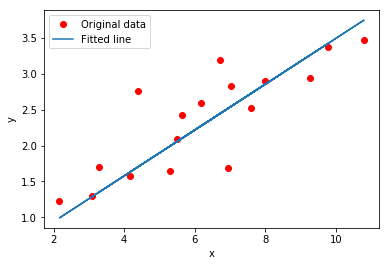

In [11]:
#Graphic display
plt.plot(train_X, train_Y, 'ro', label='Original data')
plt.plot(train_X, final_w * train_X + final_b, label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## The three ingredients of learning NN.
There are three ingredients to learning NN:
1. **The model architecture:** defines how the the output prediction $\hat{y}$ is computed from the input $X$ and the parameters $W$.
1. **The Loss function:** quantifies the difference between the output $y$ and the prediction $\hat{y}$.
1. **The optimizer:** finds a parameter setting $W^*$ that minimizes the average loss

## The parts of a basic Tensorflow program
### Basic units:
1. **the inputs:** defined as `placeholder`s
2. **The weights:** defined as `variable`s

### Nodes in the computation graph:
3. **The model** 
4. **The loss function** 
5. **The optimizer** 

### The session
Defines the order in which the elements of the computation graph are computed.

### See you next time
* logistic regression.